## Wind Farm B Layout Based on Wake Effect

In [1]:
import pandas as pd
import numpy as np
import os

# Dataset IDs for Wind Farm B
dataset_ids = [2, 7, 19, 21, 23, 27, 34, 52, 53, 74, 77, 82, 83, 86, 87]

input_dir = r"D:\Master Thesis New Data Set\CARE DATA SET\CARE_To_Compare\Wind Farm B\Wind Farm B\datasets"

scores = []

for dataset_id in dataset_ids:
    file_path = os.path.join(input_dir, f"{dataset_id}.csv")
    df = pd.read_csv(file_path, delimiter=';')

    # Set negative power to 0
    df['power_62_avg'] = df['power_62_avg'].clip(lower=0)

    # Filter for normal operation
    df['relative_wind_direction'] = (df['sensor_4_avg'] - df['sensor_21_avg'] + 540) % 360 - 180
    normal = df[
        (df['sensor_10_avg'] <= 2) &
        (df['sensor_10_avg'] >= -5) &
        (df['relative_wind_direction'] >= -10) &
        (df['relative_wind_direction'] <= 10) &
        (df['status_type_id'] == 0) &
        (df['train_test'] == 'train')
    ]

    # Rated power (max observed)
    rated_power = normal['power_62_avg'].max()
    if rated_power == 0 or np.isnan(rated_power):
        continue

    # Mid-range (6–10 m/s)
    subset = normal[(normal['wind_speed_61_avg'] >= 6) & (normal['wind_speed_61_avg'] <= 10)]
    avg_ratio = subset['power_62_avg'].mean() / rated_power
    scores.append((dataset_id, avg_ratio))

# Sort by score
scores.sort(key=lambda x: x[1], reverse=True)

# Classification: Top 25% = Strict, Bottom 25% = Lenient, rest Neutral
n = len(scores)
strict_cut = int(n * 0.25)
lenient_cut = int(n * 0.75)

for i, (dataset_id, avg_ratio) in enumerate(scores):
    if i < strict_cut:
        pipeline = "Strict"
    elif i >= lenient_cut:
        pipeline = "Lenient"
    else:
        pipeline = "Neutral"
    print(f"Dataset {dataset_id}: avg_ratio={avg_ratio:.3f} → {pipeline}")


Dataset 52: avg_ratio=0.372 → Strict
Dataset 34: avg_ratio=0.369 → Strict
Dataset 2: avg_ratio=0.362 → Strict
Dataset 74: avg_ratio=0.356 → Neutral
Dataset 7: avg_ratio=0.356 → Neutral
Dataset 19: avg_ratio=0.355 → Neutral
Dataset 83: avg_ratio=0.353 → Neutral
Dataset 21: avg_ratio=0.347 → Neutral
Dataset 87: avg_ratio=0.340 → Neutral
Dataset 82: avg_ratio=0.340 → Neutral
Dataset 77: avg_ratio=0.339 → Neutral
Dataset 86: avg_ratio=0.338 → Lenient
Dataset 27: avg_ratio=0.337 → Lenient
Dataset 23: avg_ratio=0.334 → Lenient
Dataset 53: avg_ratio=0.331 → Lenient


In [1]:
# New dataset (avg_ratio per dataset)
data = {
    52: 0.372, 34: 0.369,  2: 0.362,
    74: 0.356,  7: 0.356, 19: 0.355,
    83: 0.353, 21: 0.347, 87: 0.340,
    82: 0.340, 77: 0.339, 86: 0.338,
    27: 0.337, 23: 0.334, 53: 0.331
}

# Turbine mapping (WT : dataset(s))
turbine_datasets = {
    "WT 13": [2, 7],
    "WT 11": [19, 74],
    "WT 6":  [23, 53],
    "WT 7":  [27, 87],
    "WT 14": [34, 52],
    "WT 12": [77, 86],
    "WT 0":  [21],
    "WT 5":  [82],
    "WT 2":  [83]
}

# Calculate avg_ratio per WT (mean if multiple datasets)
wt_ratios = {}
for wt, ds_list in turbine_datasets.items():
    avg_val = sum(data[ds] for ds in ds_list) / len(ds_list)
    wt_ratios[wt] = avg_val

# Determine percentile thresholds
values = sorted(wt_ratios.values(), reverse=True)
p66 = values[int(len(values) * (1/3)) - 1]  # Front cutoff
p33 = values[int(len(values) * (2/3)) - 1]  # Central cutoff

# Assign rows automatically
row_assignment = {}
for wt, ratio in wt_ratios.items():
    if ratio >= p66:
        row_assignment[wt] = "Front"
    elif ratio >= p33:
        row_assignment[wt] = "Central"
    else:
        row_assignment[wt] = "Back"

# Display table in console
print(f"{'Turbine':<6} {'Avg Ratio':<10} {'Row':<8}")
print("-" * 28)
for wt, ratio in sorted(wt_ratios.items(), key=lambda x: x[1], reverse=True):
    print(f"{wt:<6} {ratio:<10.3f} {row_assignment[wt]:<8}")


Turbine Avg Ratio  Row     
----------------------------
WT 14  0.370      Front   
WT 13  0.359      Front   
WT 11  0.355      Front   
WT 2   0.353      Central 
WT 0   0.347      Central 
WT 5   0.340      Central 
WT 7   0.339      Back    
WT 12  0.339      Back    
WT 6   0.333      Back    



Turbine Layout Table:
--------------------------------------------------
WT 14  | Score: 0.370 | Row: Front | Datasets: [34, 52]
WT 13  | Score: 0.359 | Row: Front | Datasets: [2, 7]
WT 11  | Score: 0.355 | Row: Front | Datasets: [19, 74]
WT 2   | Score: 0.353 | Row: Front | Datasets: [83]
WT 0   | Score: 0.347 | Row: Back  | Datasets: [21]
WT 5   | Score: 0.340 | Row: Back  | Datasets: [82]
WT 7   | Score: 0.339 | Row: Back  | Datasets: [27, 87]
WT 12  | Score: 0.339 | Row: Back  | Datasets: [77, 86]
WT 6   | Score: 0.333 | Row: Back  | Datasets: [23, 53]
--------------------------------------------------


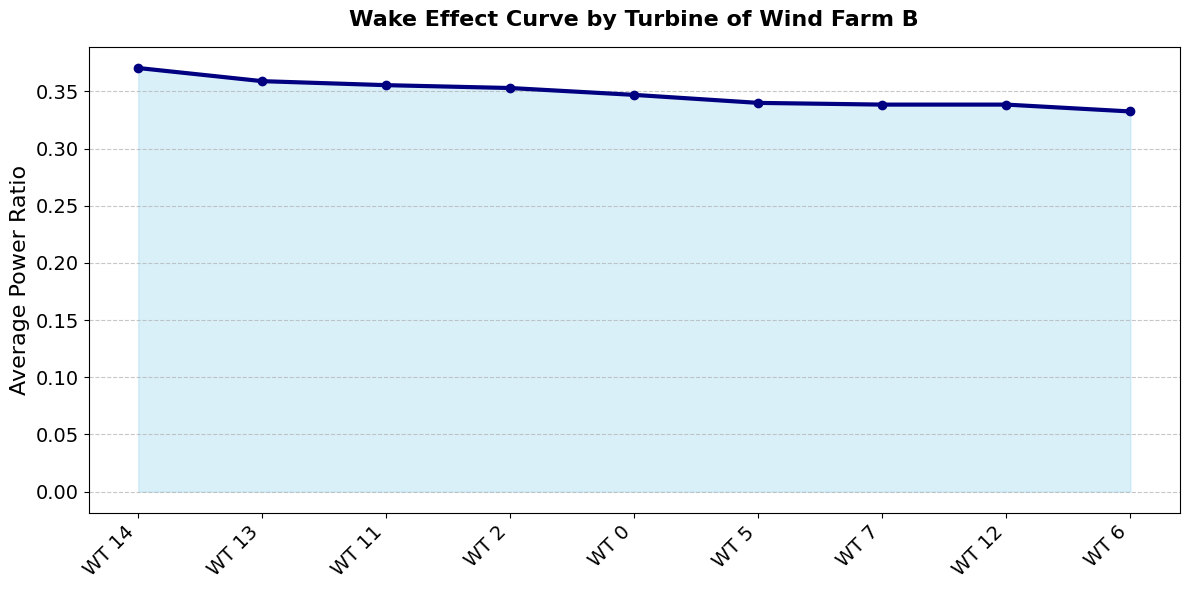

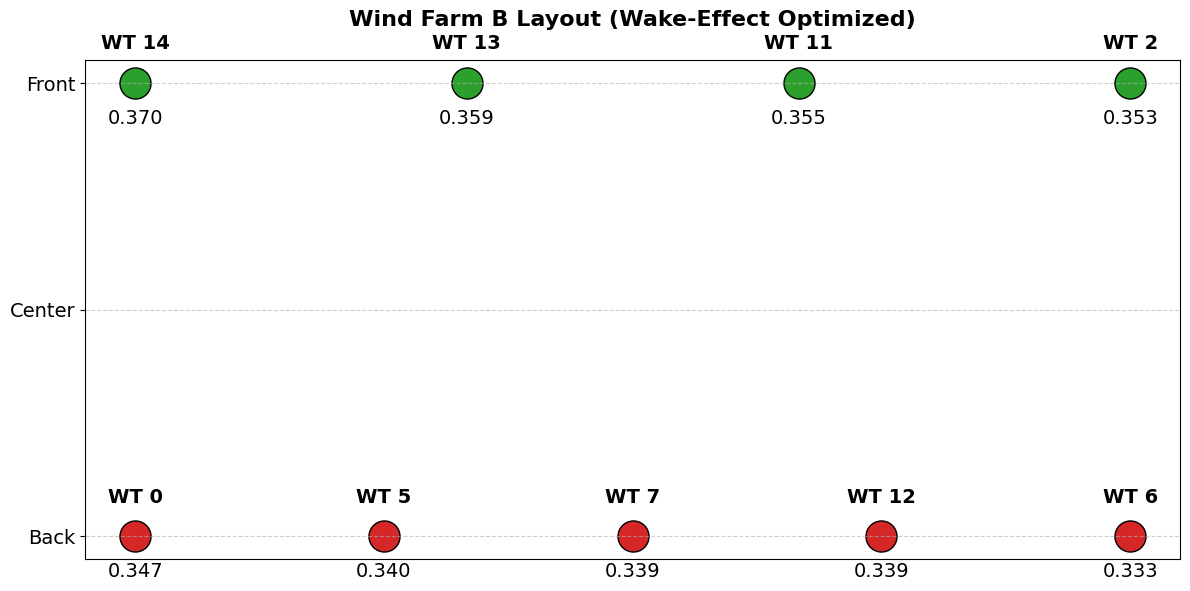

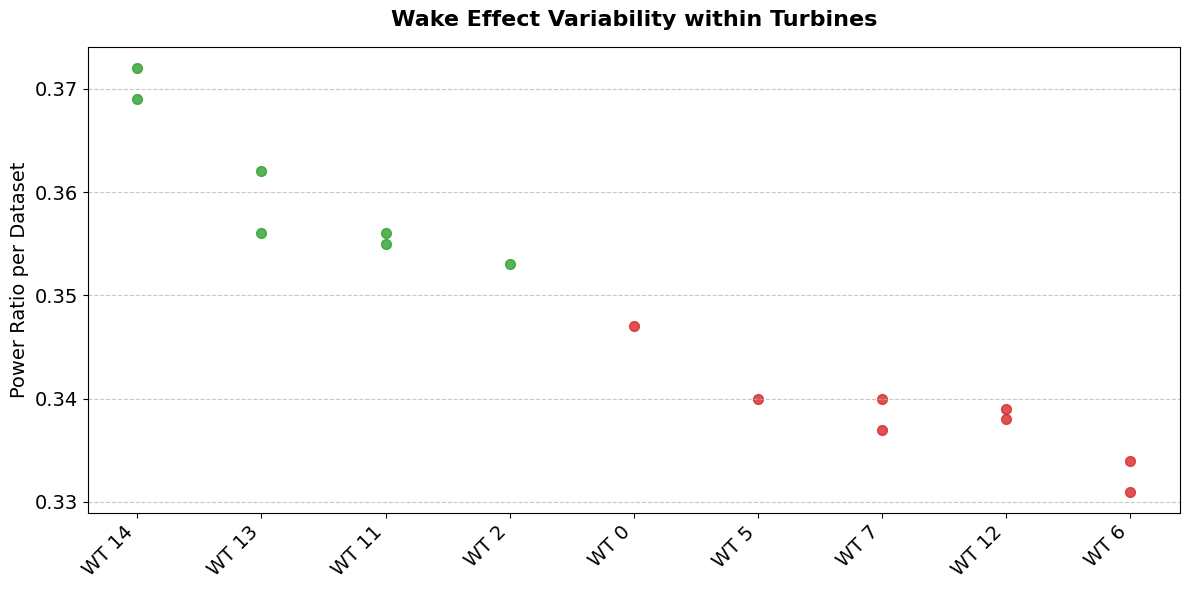

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ Data & Turbine Mapping
# =========================
data_scores = {
    52: 0.372, 34: 0.369,  2: 0.362,
    74: 0.356,  7: 0.356, 19: 0.355,
    83: 0.353, 21: 0.347, 87: 0.340,
    82: 0.340, 77: 0.339, 86: 0.338,
    27: 0.337, 23: 0.334, 53: 0.331
}

# Turbine mapping (WT : dataset(s))
wt_map = {
    "WT 14": [34, 52],
    "WT 13": [2, 7],
    "WT 11": [19, 74],
    "WT 2":  [83],
    "WT 0":  [21],
    "WT 5":  [82],
    "WT 7":  [27, 87],
    "WT 12": [77, 86],
    "WT 6":  [23, 53]
}
# =========================
# 2️⃣ Calculate Turbine Scores
# =========================
turbine_scores = {}
turbine_datasets = {}
for wt, datasets in wt_map.items():
    vals = [data_scores[d] for d in datasets if d in data_scores]
    if vals:
        turbine_scores[wt] = np.mean(vals)
        turbine_datasets[wt] = vals

# =========================
# 3️⃣ Assign Rows by Median (Higher score = Front)
# =========================
layout_df = pd.DataFrame(list(turbine_scores.items()), columns=["Turbine", "Score"])

def assign_row(score):
    return "Front" if score > 0.350 else "Back"

layout_df["Row"] = layout_df["Score"].apply(assign_row)

colors = {"Front": "#2ca02c", "Back": "#d62728"}

# =========================
# 4️⃣ Print Table: Turbine, Dataset, Row
# =========================
print("\nTurbine Layout Table:")
print("-" * 50)
for _, row in layout_df.iterrows():
    wt = row["Turbine"]
    score = row["Score"]
    assigned_row = row["Row"]
    datasets = wt_map[wt]
    print(f"{wt:<6} | Score: {score:.3f} | Row: {assigned_row:<5} | Datasets: {datasets}")
print("-" * 50)

# =========================
plt.figure(figsize=(12, 6))
plt.plot(layout_df["Turbine"], layout_df["Score"], marker='o', linewidth=3, color="navy")
plt.fill_between(layout_df["Turbine"], layout_df["Score"], color="skyblue", alpha=0.3)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Average Power Ratio", fontsize=16)

plt.title("Wake Effect Curve by Turbine of Wind Farm B", fontsize=16, weight="bold", pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("wind_farm_B_wake.png", dpi=300, bbox_inches="tight")
plt.show()


# =========================
# 3️⃣ Wind Farm Layout Diagram
# =========================
plt.figure(figsize=(12, 6))
row_y = {"Front": 3, "Center": 2, "Back": 1}
for row_name in ["Front", "Center", "Back"]:
    row_turbines = layout_df[layout_df["Row"] == row_name]
    x_positions = np.linspace(0, 10, len(row_turbines))
    for x, (wt, score, row) in zip(x_positions, row_turbines[["Turbine", "Score", "Row"]].values):
        plt.scatter(x, row_y[row], s=500, color=colors[row], edgecolor="black")
        plt.text(x, row_y[row]+0.15, wt, ha="center", fontsize=14, weight="bold")
        plt.text(x, row_y[row]-0.18, f"{score:.3f}", ha="center", fontsize=14)

plt.yticks([1, 2, 3], ["Back", "Center", "Front"], fontsize=14)
plt.xticks([])
plt.title("Wind Farm B Layout (Wake-Effect Optimized)", fontsize=16, weight="bold", pad=25)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("wind_farm_layout_B.png", dpi=300, bbox_inches="tight")  # High-res PN
plt.show()

# =========================
# 4️⃣ Wake Variability Scatter
# =========================
layout_df_sorted = layout_df.sort_values("Score", ascending=False)
plt.figure(figsize=(12, 6))
for i, wt in enumerate(layout_df_sorted["Turbine"]):
    vals = turbine_datasets[wt]
    plt.scatter([i]*len(vals), vals, color=colors[layout_df_sorted.iloc[i]["Row"]], s=50, alpha=0.8)
plt.xticks(range(len(layout_df_sorted)), layout_df_sorted["Turbine"], rotation=45, ha="right",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Power Ratio per Dataset", fontsize=14)
plt.title("Wake Effect Variability within Turbines", fontsize=16, weight="bold", pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("wind_farm_layout_wakeeee_B.png", dpi=300, bbox_inches="tight")  # High-res PN
plt.show()

